<a href="https://colab.research.google.com/github/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/blob/main/11_1_sentiment_analysis_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using BERT
This code implements a sentiment analysis model using BERT (Bidirectional Encoder Representations from Transformers) with the PyTorch framework. The model is designed to classify movie reviews as either positive or negative using the IMDb dataset, which is retrieved and preprocessed using the Hugging Face datasets library. The code defines a custom dataset class to handle tokenization and batching of text data, leveraging the BERT tokenizer. The SentimentClassifier model is built on top of the BERT architecture, incorporating a dropout layer and a linear classification layer.

The training process involves iterating over the dataset in mini-batches, updating model weights using the AdamW optimizer, and adjusting the learning rate with a linear scheduler. During training, the accuracy and loss are monitored and displayed via a progress bar to track the model’s performance over time. The evaluation function computes the model’s accuracy and loss on a validation set to assess its generalization capability.

The results of the training and validation processes are visualized through plotted graphs of accuracy and loss across epochs. After training, the model is tested on a sample input to demonstrate its prediction capabilities. This implementation provides a comprehensive framework for sentiment analysis using state-of-the-art NLP techniques and is extensible to other text classification tasks.

In [3]:
!pip install datasets
!pip install tqdm

Epoch 1/3


Epoch Progress: 100%|██████████| 1563/1563 [04:21<00:00,  5.98it/s, accuracy=0.848, loss=0.511]


Train loss 0.345997723044681, accuracy 0.84816
Val loss 0.27435336880664735, accuracy 0.88416
Epoch 2/3


Epoch Progress: 100%|██████████| 1563/1563 [04:20<00:00,  5.99it/s, accuracy=0.926, loss=0.0931]


Train loss 0.20443146337974896, accuracy 0.9258
Val loss 0.32938395138390203, accuracy 0.88036
Epoch 3/3


Epoch Progress: 100%|██████████| 1563/1563 [04:21<00:00,  5.99it/s, accuracy=0.966, loss=0.00458]


Train loss 0.11988208203347697, accuracy 0.96632
Val loss 0.45227144691888754, accuracy 0.89056


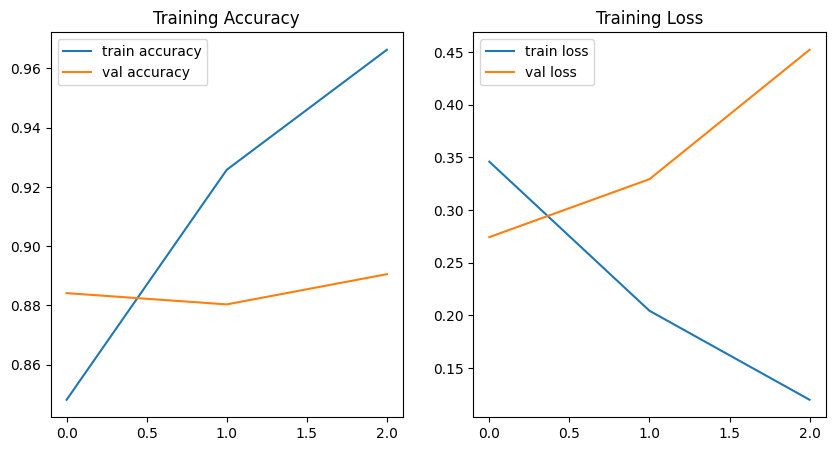

Text: I really enjoyed this movie
Sentiment: positive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Step 1: Prepare the Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Step 2: Initialize the BERT model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Step 3: Training Function
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0

    # Add a progress bar using tqdm
    loop = tqdm(data_loader, leave=True)
    for d in loop:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update the progress bar with loss and accuracy
        loop.set_description(f'Epoch Progress')
        loop.set_postfix(loss=loss.item(), accuracy=correct_predictions.double().cpu().numpy() / n_examples)

    return correct_predictions.double().cpu().numpy() / n_examples, np.mean(losses)

# Step 4: Evaluation Function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double().cpu().numpy() / n_examples, np.mean(losses)

# Step 5: Plotting Function
def plot_training_history(history):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='val accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.title('Training Loss')
    plt.legend()

    plt.show()

# Step 6: Main function to train and evaluate
def main():
    # Load IMDb dataset from Hugging Face Datasets library
    dataset = load_dataset("imdb")

    # Hyperparameters
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 3
    LEARNING_RATE = 2e-5

    # Split dataset into training and validation sets
    train_texts = dataset['train']['text']
    train_labels = dataset['train']['label']
    val_texts = dataset['test']['text']
    val_labels = dataset['test']['label']

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Model, loss, optimizer
    model = SentimentClassifier(n_classes=2)
    model = model.to('cuda')

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to('cuda')

    # Training loop
    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, 'cuda', scheduler, len(train_dataset))
        val_acc, val_loss = eval_model(model, val_loader, loss_fn, 'cuda', len(val_dataset))

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'Train loss {train_loss}, accuracy {train_acc}')
        print(f'Val loss {val_loss}, accuracy {val_acc}')

    # Plot training history
    plot_training_history(history)

    # Test the model on a new example
    test_text = "I really enjoyed this movie"
    encoded_test = tokenizer.encode_plus(
        test_text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_test['input_ids'].to('cuda')
    attention_mask = encoded_test['attention_mask'].to('cuda')

    model.eval()
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        label = 'positive' if prediction.item() == 1 else 'negative'

    print(f'Text: {test_text}')
    print(f'Sentiment: {label}')

if __name__ == "__main__":
    main()